# Recommendation Systems Exhibition

In [1]:
# Import packages used throughout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from data import import_data 
from methods import (utils, losses, matrix_factorization, AutoRec,   
    neural_collaborative_filtering, sequence_aware)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## Datasets

### Movielens Data

In [2]:
# Import data
names = ["user_id", "item_id", "rating", "timestamp"]
data = pd.read_csv("data/u.data", delimiter='\t', names = names, engine = "python")
num_users = data.user_id.unique().shape[0]
num_items = data.item_id.unique().shape[0]

## Explicit Models (with MovieLens)

### Matrix Factorization

In [3]:
# Obtain the data
num_users, num_items, train_iter, test_iter = import_data.split_and_load_ml100k(data,
    num_users, num_items, device, test_ratio = 0.1, batch_size=512)

In [4]:
# Define evaluator
def evaluator(net, test_iter):
    rmse_list = []
    for _, (users, items, ratings) in enumerate(test_iter):
        r_hat = net(users, items)
        rmse_value = torch.sqrt(((r_hat - ratings)**2).mean())
        rmse_list.append(float(rmse_value))

    return np.mean(np.array(rmse_list))

In [5]:
# Prepare model
lr, num_epochs, wd = 0.002, 20, 1e-5

mf_net = matrix_factorization.MF(30, num_users, num_items).to(device)
optimizer = optim.Adam(mf_net.parameters(), lr = lr, weight_decay = wd)

In [6]:
# Train and evaluate model
rmse_list = []
loss_list = []
for epoch in range(num_epochs):
    total_loss, num_samples = 0, 0

    # Train each batch
    mf_net.train()
    for i, (users, items, ratings) in enumerate(train_iter):
        optimizer.zero_grad()

        predictions = mf_net(users, items)
        output = ((predictions - ratings)**2).mean()
        output.backward()
        optimizer.step()

        total_loss += output
        num_samples += users.shape[0]
    
    # Evaluate
    mf_net.eval()
    rmse = evaluator(mf_net, test_iter)
    rmse_list.append(rmse)
    loss_list.append(total_loss/num_samples)

    print(f"Epoch {epoch}:\n\tloss = {total_loss/num_samples}\n\trmse = {rmse}")

Epoch 0:
	loss = 0.01788276806473732
	rmse = 1.938893437385559
Epoch 1:
	loss = 0.002736873459070921
	rmse = 1.21602463722229
Epoch 2:
	loss = 0.0018846499733626842
	rmse = 1.0958380103111267
Epoch 3:
	loss = 0.0017537240637466311
	rmse = 1.0733677744865417
Epoch 4:
	loss = 0.0017041999381035566
	rmse = 1.0643903613090515
Epoch 5:
	loss = 0.0016729634953662753
	rmse = 1.0558914542198181
Epoch 6:
	loss = 0.0016479778569191694
	rmse = 1.0576258897781372
Epoch 7:
	loss = 0.0016233051428571343
	rmse = 1.0557850003242493
Epoch 8:
	loss = 0.0016047919634729624
	rmse = 1.05287504196167
Epoch 9:
	loss = 0.0015864224405959249
	rmse = 1.0516024231910706
Epoch 10:
	loss = 0.001569243730045855
	rmse = 1.048521876335144
Epoch 11:
	loss = 0.0015538785373792052
	rmse = 1.0464833974838257
Epoch 12:
	loss = 0.001538289594464004
	rmse = 1.0472553372383118
Epoch 13:
	loss = 0.0015192971331998706
	rmse = 1.0461549162864685
Epoch 14:
	loss = 0.0014999235281720757
	rmse = 1.047378122806549
Epoch 15:
	loss =

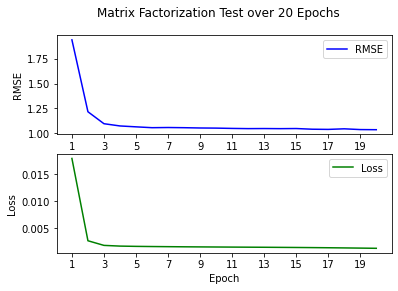

In [7]:
# Visualize
fig, ax = plt.subplots(2)
fig.suptitle(f"Matrix Factorization Test over {num_epochs} Epochs")

x_vals = list(range(1, num_epochs + 1))
ax[0].plot(x_vals, rmse_list, label = "RMSE", color = "blue")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(x_vals[::2])
ax[0].legend()

ax[1].plot(x_vals, loss_list, label = "Loss", color = "green")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_xticks(x_vals[::2])
ax[1].legend()

### AutoRec

In [8]:
# Obtain the data
train_data, test_data = import_data.split_data_ml100k(data, num_users, num_items)

_, _, _, train_inter_matrix = import_data.load_data_ml100k(train_data, num_users, num_items)
_, _, _, test_inter_matrix = import_data.load_data_ml100k(test_data, num_users, num_items)

train_inter_tensor = torch.from_numpy(train_inter_matrix).to(torch.float)
test_inter_tensor = torch.from_numpy(test_inter_matrix).to(torch.float)

train_iter = DataLoader(train_inter_tensor, shuffle = True, batch_size = 256,
    num_workers = 4)
test_iter = DataLoader(test_inter_tensor, shuffle = False, batch_size = 1024,
    num_workers = 4)

In [9]:
# Define evaluator
def evaluator(network, test_iter, device):
    rmse_list = []
    for _, users_ratings in enumerate(test_iter):
        users_ratings = users_ratings.to(device)
        recons = network(users_ratings)
        rmse_value = torch.sqrt(
            ((torch.sign(users_ratings) * recons - users_ratings)**2).mean())
        rmse_list.append(float(rmse_value))

    return np.mean(np.array(rmse_list))

In [10]:
# Prepare model
lr, num_epochs, wd = 0.002, 25, 1e-5

autorec_net = AutoRec(500, num_users).to(device)
optimizer = optim.Adam(autorec_net.parameters(), lr = lr, weight_decay=wd)

In [11]:
# Train and evaluate model
rmse_list = []
loss_list = []
for epoch in range(num_epochs):
    total_loss, num_samples = 0, 0

    # Train each batch
    autorec_net.train()
    for i, user_ratings in enumerate(train_iter):
        user_ratings = user_ratings.to(device)
        optimizer.zero_grad()

        predictions = autorec_net(user_ratings)
        output = ((predictions - user_ratings)**2).mean()
        output.backward()
        optimizer.step()

        total_loss += output
        num_samples += user_ratings.shape[0]
    
    # Evaluate
    autorec_net.eval()
    rmse = evaluator(autorec_net, test_iter, device)
    rmse_list.append(rmse)
    loss_list.append(total_loss/num_samples)

    print(f"Epoch {epoch}:\n\tloss = {total_loss/num_samples}\n\trmse = {rmse}")

Epoch 0:
	loss = 0.002089346293359995
	rmse = 0.22827046737074852
Epoch 1:
	loss = 0.0012450127396732569
	rmse = 0.2134353294968605
Epoch 2:
	loss = 0.0007309825159609318
	rmse = 0.2069106176495552
Epoch 3:
	loss = 0.000592020689509809
	rmse = 0.20410972461104393
Epoch 4:
	loss = 0.000485582510009408
	rmse = 0.20115626230835915
Epoch 5:
	loss = 0.0004154314810875803
	rmse = 0.20023371651768684
Epoch 6:
	loss = 0.0003560574259608984
	rmse = 0.19806016981601715
Epoch 7:
	loss = 0.00031845984631218016
	rmse = 0.19604692235589027
Epoch 8:
	loss = 0.0002874613564927131
	rmse = 0.19538172334432602
Epoch 9:
	loss = 0.0002792445884551853
	rmse = 0.19317437335848808
Epoch 10:
	loss = 0.000258593907346949
	rmse = 0.18901874870061874
Epoch 11:
	loss = 0.00023502651310991496
	rmse = 0.18847589194774628
Epoch 12:
	loss = 0.0002182369353249669
	rmse = 0.18514589220285416
Epoch 13:
	loss = 0.000202162133064121
	rmse = 0.1832520216703415
Epoch 14:
	loss = 0.00018970003293361515
	rmse = 0.1822114065289

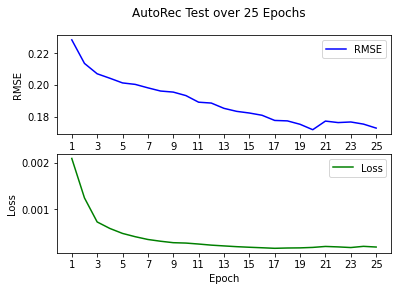

In [12]:
# Visualize
fig, ax = plt.subplots(2)
fig.suptitle(f"AutoRec Test over {num_epochs} Epochs")

x_vals = list(range(1, num_epochs + 1))
ax[0].plot(x_vals, rmse_list, label = "RMSE", color = "blue")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(x_vals[::2])
ax[0].legend()

ax[1].plot(x_vals, loss_list, label = "Loss", color = "green")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_xticks(x_vals[::2])
ax[1].legend()

## Implicit Models (with MovieLens)

In [13]:
# Define metrics
def hit_and_auc(rankedlist, test_item, k):
    test_item = int(test_item)
    hits_k = test_item in rankedlist[:k]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist) if int(val) == test_item]

    max_num = len(rankedlist) - 1
    auc = 1.0 * (max_num - hits_all[0][0]) / \
        max_num if len(hits_all) > 0 else 0
    return hits_k, auc

## NeuMF

In [14]:
# Prepare Dataset
batch_size = 1024
train_data, test_data = import_data.split_data_ml100k(data, num_users,
    num_items,'seq-aware')

# Training data
users_train, items_train, _, interactions = import_data.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
train_dataset = neural_collaborative_filtering.PRDataset(users_train, items_train, 
    interactions, num_items)
train_iter = DataLoader(train_dataset, batch_size = batch_size, shuffle = True,
    num_workers = 4)

# Test data
_, _, _, test_interactions = import_data.load_data_ml100k(test_data, num_users, num_items,
    feedback="implicit")

In [15]:
# Define evaluator
def evaluate_ranking_bpr(net, test_input, interactions, num_users, num_items, device):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_items)])
    for u in range(num_users):
        neg_items = list(all_items - set(interactions[u]))
        user_ids, item_ids, scores = [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        test_dataset = TensorDataset(torch.from_numpy(np.array(user_ids)).to(device),    
            torch.from_numpy(np.array(item_ids)).to(device))
        test_data_iter = DataLoader(test_dataset, shuffle=False, batch_size=1024)

        for _, (user_idxs, item_idxs) in enumerate(test_data_iter):
            scores.extend(list(net(user_idxs, item_idxs).cpu().detach().numpy()))
        item_scores = list(zip(item_ids, scores))

        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        
        temp = hit_and_auc(ranked_items[u], test_input[u][0], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

In [16]:
# Define weight initializer
def weights_init(module):
    if isinstance(module, nn.Embedding) or isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, std=0.01)

In [17]:
# Create and initialize model
lr, num_epochs, wd = 0.01, 10, 1e-5

neuMF_net = neural_collaborative_filtering.NeuMF(10, num_users, num_items,
    nums_hiddens=[10, 10, 10]).to(device)
neuMF_net.apply(weights_init)
loss = losses.BPR_Loss
optimizer = optim.Adam(neuMF_net.parameters(), lr = lr, weight_decay=wd)

In [18]:
# Train and evaluate the model
hit_rate_list = []
auc_list = []
for epoch in range(num_epochs):
    accumulator, l = utils.Accumulator(2), 0.

    # Train each batch
    neuMF_net.train()
    for i, (user_idxs, item_idxs, neg_items) in enumerate(train_iter):
        user_idxs = user_idxs.to(device)
        item_idxs = item_idxs.to(device)
        neg_items = neg_items.to(device)

        optimizer.zero_grad()

        p_pos = neuMF_net(user_idxs, item_idxs)
        p_neg = neuMF_net(user_idxs, neg_items)

        total_loss = loss(p_pos, p_neg)
        total_loss.backward()
        optimizer.step()
        accumulator.add(total_loss, user_idxs.shape[0])

    # Evaluate
    neuMF_net.eval()
    hit_rate, auc = evaluate_ranking_bpr(neuMF_net, test_interactions, interactions, 
        num_users, num_items, device)
    hit_rate_list.append(hit_rate)
    auc_list.append(auc)

    print(f"Epoch {epoch}:\n\tloss = {accumulator[0]/accumulator[1]}\n\thit_rate = {hit_rate}\n\tauc = {auc}")

Epoch 0:
	loss = 0.565872418360215
	hit_rate = 0.19300106044538706
	auc = 0.7886980502978469
Epoch 1:
	loss = 0.4962613617679365
	hit_rate = 0.24072110286320256
	auc = 0.8057591749840258
Epoch 2:
	loss = 0.46308221378675124
	hit_rate = 0.25874867444326616
	auc = 0.8457555953713054
Epoch 3:
	loss = 0.4429795441102369
	hit_rate = 0.26617179215270415
	auc = 0.8534931166834597
Epoch 4:
	loss = 0.4343540217798764
	hit_rate = 0.24390243902439024
	auc = 0.8555678856820591
Epoch 5:
	loss = 0.4284482353037385
	hit_rate = 0.2704135737009544
	auc = 0.8590943417899921
Epoch 6:
	loss = 0.424213501963654
	hit_rate = 0.2757158006362672
	auc = 0.8567305114793828
Epoch 7:
	loss = 0.42152572427424206
	hit_rate = 0.27783669141039236
	auc = 0.8595187212845667
Epoch 8:
	loss = 0.4170604730341495
	hit_rate = 0.2841993637327678
	auc = 0.8585757923426559
Epoch 9:
	loss = 0.41576668447325466
	hit_rate = 0.2948038176033934
	auc = 0.8601690113284185


(0.0, 1.0)

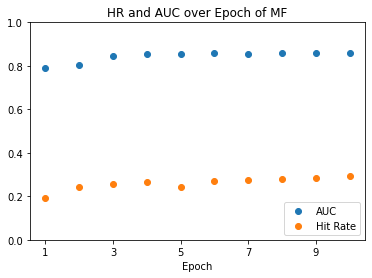

In [19]:
# Visualize
x = list(range(1, num_epochs + 1))
plt.scatter(x, auc_list, label = "AUC")
plt.scatter(x, hit_rate_list, label = "Hit Rate")
plt.title("HR and AUC over Epoch of MF")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")
plt.xticks(x[0::2])
plt.ylim((0, 1))

## Caser

In [20]:
# Prepare Dataset
TARGET_NUM, L, batch_size = 1, 5, 4096
train_data, test_data = import_data.split_data_ml100k(data, num_users, num_items,
                                                        'seq-aware')

# Training Data
users_train, items_train, _, candidates = import_data.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
train_seq_data = sequence_aware.SeqDataset(users_train, items_train, L, num_users,
                                            num_items, candidates)
train_iter = DataLoader(train_seq_data, batch_size=batch_size, shuffle=True, num_workers=4)

# Test Data
_, _, _, test_iter = import_data.load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
test_seq_iter = train_seq_data.test_seq

In [21]:
# Define evaluator
def evaluate_ranking_bpr(net, test_input, test_seq_iter, interactions, num_users, num_items, device):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_items)])
    for u in range(num_users):
        neg_items = list(all_items - set(interactions[u]))
        user_ids, item_ids, scores = [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        test_dataset = TensorDataset(torch.from_numpy(np.array(user_ids)).type(torch.long).to(device),
                                    torch.from_numpy(np.array(item_ids)).type(torch.long).to(device),
                                    torch.from_numpy(np.array(test_seq_iter[user_ids, :])).type(torch.long).to(device))
        test_data_iter = DataLoader(
            test_dataset, shuffle=False, batch_size=1024)

        for _, (user_idxs, item_idxs, seq) in enumerate(test_data_iter):
            scores.extend(
                list(net(user_idxs, seq, item_idxs).cpu().detach().numpy()))
        item_scores = list(zip(item_ids, scores))

        ranked_list[u] = sorted(
            item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]

        temp = hit_and_auc(ranked_items[u], test_input[u][0], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

In [22]:
# Weight initializer
def weights_init(module):
    if (isinstance(module, nn.Embedding) or isinstance(module, nn.Linear)
            or isinstance(module, nn.Conv2d)):
        nn.init.normal_(module.weight, std=0.01)

In [23]:
# Create and initialize model
lr, num_epochs, wd = 0.04, 10, 1e-5

caser_net = sequence_aware.Caser(10, num_users, num_items, L).to(device)
caser_net.apply(weights_init)
loss = losses.BPR_Loss
optimizer = optim.Adam(caser_net.parameters(), lr = lr, weight_decay=wd)

In [24]:
# Train and evaluate the model
hit_rate_list = []
auc_list = []
for epoch in range(num_epochs):
    accumulator, l = utils.Accumulator(2), 0.

    # Train each batch
    caser_net.train()
    for i, (user_idxs, seq, pos_tgts, neg_tgts) in enumerate(train_iter):
        user_idxs = user_idxs.to(device)
        seq = seq.to(device)
        pos_tgts = pos_tgts.to(device)
        neg_tgts = neg_tgts.to(device)

        optimizer.zero_grad()

        user_idxs = user_idxs.type(torch.long)
        seq = seq.type(torch.long)
        pos_tgts = pos_tgts.type(torch.long)
        neg_tgts = neg_tgts.type(torch.long)

        p_pos = caser_net(user_idxs, seq, pos_tgts)
        p_neg = caser_net(user_idxs, seq, neg_tgts)

        total_loss = loss(p_pos, p_neg)
        total_loss.backward()
        optimizer.step()
        accumulator.add(total_loss, user_idxs.shape[0])

    # Evaluate
    caser_net.eval()
    hit_rate, auc = evaluate_ranking_bpr(
        caser_net, test_iter, test_seq_iter, candidates, num_users, num_items, device)
    hit_rate_list.append(hit_rate)
    auc_list.append(auc)

    print(
        f"Epoch {epoch}:\n\tloss = {accumulator[0]/accumulator[1]}\n\thit_rate = {hit_rate}\n\tauc = {auc}")

Epoch 0:
	loss = 0.41143472349688437
	hit_rate = 0.20360551431601273
	auc = 0.7989752717193683
Epoch 1:
	loss = 0.2680748731699649
	hit_rate = 0.2704135737009544
	auc = 0.8536234707967996
Epoch 2:
	loss = 0.1937177418343291
	hit_rate = 0.32025450689289503
	auc = 0.8737551224020531
Epoch 3:
	loss = 0.1633961688205832
	hit_rate = 0.33510074231177095
	auc = 0.8745586918216827
Epoch 4:
	loss = 0.15246144114581642
	hit_rate = 0.344644750795334
	auc = 0.8821221367388834
Epoch 5:
	loss = 0.1395445326099346
	hit_rate = 0.35949098621421
	auc = 0.8851620577040383
Epoch 6:
	loss = 0.13261442418363398
	hit_rate = 0.3796394485683987
	auc = 0.8848349485818848
Epoch 7:
	loss = 0.12715276632943584
	hit_rate = 0.4029692470837752
	auc = 0.8839866166315438
Epoch 8:
	loss = 0.12459191936146717
	hit_rate = 0.39236479321314954
	auc = 0.883355690471528
Epoch 9:
	loss = 0.12023694722810283
	hit_rate = 0.39766702014846234
	auc = 0.8842235199582562


(0.0, 1.0)

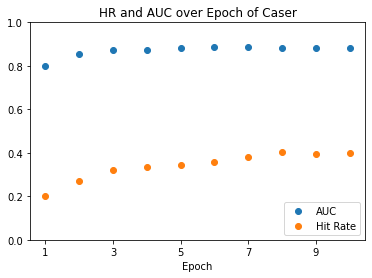

In [25]:
# Visualize
x = list(range(1, num_epochs + 1))
plt.scatter(x, auc_list, label = "AUC")
plt.scatter(x, hit_rate_list, label = "Hit Rate")
plt.title("HR and AUC over Epoch of Caser")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")
plt.xticks(x[0::2])
plt.ylim((0, 1))